# Net (using keras)

## Using drive data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install --upgrade keras

     |████████████████████████████████| 337kB 6.6MB/s 
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4


## Import

In [0]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
# keras
from keras.utils import to_categorical
from keras.layers import Concatenate, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.models import load_model
# application
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2

Using TensorFlow backend.


## Using gpu

In [0]:
!nvidia-smi

Thu Aug 29 02:40:39 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## load data

In [0]:
root_path = 'drive/My Drive/acer_intern/data/New'
saved_path ='drive/My Drive/acer_intern/saved_model/New'

In [0]:
train_data = np.load(os.path.sep.join([root_path, 'train_data.npy']))
train_label = np.load(os.path.sep.join([root_path, 'train_label.npy']))
test_data = np.load(os.path.sep.join([root_path, 'test_data.npy']))
test_label = np.load(os.path.sep.join([root_path, 'test_label.npy']))
val_data = np.load(os.path.sep.join([root_path, 'val_data.npy']))
val_label = np.load(os.path.sep.join([root_path, 'val_label.npy']))

In [0]:
print("train_data : \t", train_data[:1800].shape)
print("train_label : \t", train_label.shape)
print("test_data : \t", test_data.shape)
print("test_label : \t", test_label.shape)
print("val_data : \t", val_data.shape)
print("val_label : \t", val_label.shape)

train_data : 	 (1800, 1000, 1000, 1)
train_label : 	 (2682,)
test_data : 	 (100, 1000, 1000, 1)
test_label : 	 (100,)
val_data : 	 (100, 1000, 1000, 1)
val_label : 	 (100,)


## 整理 data

In [0]:
# To categorical
train_label = to_categorical(train_label)
test_label = to_categorical(test_label)
val_label = to_categorical(val_label)

data_shape = ((train_data, train_label,'train'), (test_data, test_label,'test'), (val_data, val_label,'validation'))
for data,label,using in data_shape:
    print("The shape of {} data : {}".format(using, data.shape))
    print("The shape of {} label : {}\n".format(using, label.shape))
    
# # validation data 太多，我們隨機取400個來用
# train_data = train_data[:-1]   
# train_label = train_label[:-1]
# np.random.seed(3)
# np.random.shuffle(val_data)
# np.random.seed(3)
# np.random.shuffle(val_label)
# val_data = val_data[:100]
# val_label = val_label[:100]

# print("============\n   Renew   \n============")
# data_shape = ((train_data, train_label,'train'), (test_data, test_label,'test'), (val_data, val_label,'validation'))
# for data,label,using in data_shape:
#     print("The shape of {} data : {}".format(using, data.shape))
#     print("The shape of {} label : {}\n".format(using, label.shape))

The shape of train data : (2682, 1000, 1000, 1)
The shape of train label : (2682, 2)

The shape of test data : (100, 1000, 1000, 1)
The shape of test label : (100, 2)

The shape of validation data : (100, 1000, 1000, 1)
The shape of validation label : (100, 2)



## MobileNet model

In [0]:
img_input = Input(shape=(800,800,1))
img_conc = Concatenate()([img_input, img_input, img_input])    

mobileNet = MobileNet(include_top=True, 
                         weights=None,
                         input_tensor=img_conc,
                         input_shape=(800, 800, 3),
                         pooling=None,
                         classes=2)

mobileNet.summary()

# Definite the callback function
callbacks_list = [EarlyStopping(monitor='val_loss',
                                patience=10),
                  ModelCheckpoint(filepath=os.path.sep.join([root_path, 'mobileNet.h5']),
                                  monitor='val_loss',
                                  save_best_only=True)]

# Compile
mobileNet.compile(loss='binary_crossentropy',
                       optimizer=Adam(),
                       metrics=['accuracy'])

# inismtialize the number of epochs and batch size
EPOCHS = 100
BS = 10

# train the model
mobileNet.fit(x=train_data, 
              y=train_label, 
              batch_size=BS, 
              epochs=EPOCHS, 
              validation_data=(val_data, val_label), 
              callbacks=callbacks_list)

Model: "mobilenet_1.00_800"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 800, 800, 1)  0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 800, 800, 3)  0           input_2[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 801, 801, 3)  0           concatenate_2[0][0]              
_________________________________________________________________________________

In [0]:
resnet = load_model(os.path.sep.join([saved_path,"mobileNet.h5"]))
resnet.summary()
loss,acc = resnet.evaluate(test_data,test_label)
print("Acc : {}".format(acc*100))

## Resnet50

In [0]:
img_input = Input(shape=(1000,1000,1))
img_conc = Concatenate()([img_input, img_input, img_input])    

ResNet50 = ResNet50(include_top=True,
                    weights=None,
                    input_tensor=img_conc,
                    input_shape=(1000, 1000, 3),
                    pooling=None,
                    classes=2)

ResNet50.summary()

# Definite the callback function
callbacks_list = [ModelCheckpoint(filepath=os.path.sep.join([saved_path, 'resnetv2.h5']),
                                  monitor='val_loss',
                                  save_best_only=True)]

# Compile
ResNet50.compile(loss='binary_crossentropy',
                       optimizer=Adam(),
                       metrics=['accuracy'])

# inismtialize the number of epochs and batch size
EPOCHS = 100
BS = 5

# train the model
ResNet50.fit(x=train_data, 
           y=train_label, 
           batch_size=BS, 
           epochs=EPOCHS, 
           validation_data=(val_data, val_label),  
           callbacks=callbacks_list)

W0828 15:05:49.112710 140397072385920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0828 15:05:49.144513 140397072385920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0828 15:05:49.212053 140397072385920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0828 15:05:49.264784 140397072385920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0828 15:05:49.266019

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000, 1000, 1 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1000, 1000, 3 0           input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 1006, 1006, 3 0           concatenate_1[0][0]              
___________________________________________________________________________________________

ResourceExhaustedError: ignored

In [0]:
resnet = load_model(os.path.sep.join([saved_path,"resnet50.h5"]))
resnet.summary()
loss,acc = resnet.evaluate(test_data,test_label)
print("Acc : {}".format(acc*100))

W0825 08:47:05.375573 140700299999104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0825 08:47:05.421059 140700299999104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0825 08:47:05.443744 140700299999104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0825 08:47:05.444862 140700299999104 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0825 08:47:05.445571

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1024, 1024, 1 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1024, 1024, 3 0           input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 1030, 1030, 3 0           concatenate_1[0][0]              
___________________________________________________________________________________________

## Resnet50_v2

In [0]:
img_input = Input(shape=(1024,1024,1))
img_conc = Concatenate()([img_input, img_input, img_input])    

ResNet50_V2 = ResNet50V2(include_top=True, 
                         weights=None,
                         input_tensor=img_conc,
                         input_shape=(1024, 1024, 3),
                         pooling=None,
                         classes=2)

ResNet50_V2.summary()

# Definite the callback function
callbacks_list = [ModelCheckpoint(filepath=os.path.sep.join([saved_path, 'resnet50v2.h5']),
                                  monitor='val_loss',
                                  save_best_only=True)]

# Compile
ResNet50_V2.compile(loss='binary_crossentropy',
                       optimizer=Adam(),
                       metrics=['accuracy'])

# inismtialize the number of epochs and batch size
EPOCHS = 100
BS = 5

# train the model
ResNet50_V2.fit(x=train_data, 
           y=train_label, 
           batch_size=BS, 
           epochs=EPOCHS, 
           validation_data=(val_data, val_label),  
           callbacks=callbacks_list)

W0825 00:14:26.058350 140122656872320 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0825 00:14:26.069004 140122656872320 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1024, 1024, 1 0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 1024, 1024, 3 0           input_2[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 1030, 1030, 3 0           concatenate_2[0][0]              
_________________________________________________________________________________________

In [0]:
resnet = load_model(os.path.sep.join([saved_path,'resnet50v2.h5']))
resnet.summary()
loss,acc = resnet.evaluate(test_data,test_label)
print("Acc : {}".format(acc*100))

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1024, 1024, 1 0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 1024, 1024, 3 0           input_2[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 1030, 1030, 3 0           concatenate_2[0][0]              
_________________________________________________________________________________________



```
# 此内容为代码格式
```

## Inception V3

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Input, Concatenate

img_input = Input(shape=(1000,1000,1))
img_conc = Concatenate()([img_input, img_input, img_input])    

Inception_V3 = InceptionV3(include_top=True, weights=None, input_tensor=img_conc, input_shape=(1000,1000, 3), pooling=None, classes=2)

Inception_V3.summary()

# Definite the callback function
callbacks_list = [ModelCheckpoint(filepath=os.path.sep.join([saved_path, 'InceptionV3.h5']),
                                  monitor='val_loss',
                                  save_best_only=True)]

# Compile
Inception_V3.compile(loss='binary_crossentropy',
                           optimizer=Adam(),
                           metrics=['accuracy'])

# inismtialize the number of epochs and batch size
EPOCHS = 100
BS = 5

# train the model
Inception_V3.fit(x=train_data[300:-300], 
                       y=train_label[300:-300], 
                       batch_size=BS, 
                       epochs=EPOCHS, 
                       validation_data=(val_data, val_label),  
                       callbacks=callbacks_list)

W0829 01:42:42.853353 140454319232896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4271: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000, 1000, 1 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1000, 1000, 3 0           input_1[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 499, 499, 32) 864         concatenate_1[0][0]              
_______________________________________________________________________________________

KeyboardInterrupt: ignored

In [0]:
Inception_V3 = load_model(os.path.sep.join(['drive/My Drive/acer_intern/saved_model', 'InceptionV3.h5']))
loss,acc = Inception_V3.evaluate(test_data,test_label)
print("Acc : {}".format(acc*100))

211/211 [==============================] - 37s 175ms/step
Acc : 66.82464480400085


# Final plot

## Load data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install --upgrade keras

     |████████████████████████████████| 337kB 6.4MB/s 
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4


## Import

In [0]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
# keras
from keras.utils import to_categorical
from keras.layers import Concatenate, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.models import load_model
# application
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2

Using TensorFlow backend.


## Data

In [0]:
root_path = 'drive/My Drive/acer_intern/data/New'
saved_path ='drive/My Drive/acer_intern/saved_model/New'

In [0]:
#train_data = np.load(os.path.sep.join([root_path, 'train_data.npy']))
#train_label = np.load(os.path.sep.join([root_path, 'train_label.npy']))
test_data = np.load(os.path.sep.join([root_path, 'test_data.npy']))
test_label = np.load(os.path.sep.join([root_path, 'test_label.npy']))
#val_data = np.load(os.path.sep.join([root_path, 'val_data.npy']))
#val_label = np.load(os.path.sep.join([root_path, 'val_label.npy']))

In [0]:
# To categorical
#train_label = to_categorical(train_label)
test_label = to_categorical(test_label)
#val_label = to_categorical(val_label)

In [0]:
#data_shape = ((train_data, train_label,'train'), (test_data, test_label,'test'), (val_data, val_label,'validation'))

print("The shape of {} data : {}".format('test', test_data.shape))
print("The shape of {} label : {}\n".format('test', test_label.shape))

The shape of test data : (100, 1000, 1000, 1)
The shape of test label : (100, 2)



## Compare

In [0]:
resnet34 = load_model(os.path.sep.join(['drive/My Drive/acer_intern/saved_model/New', 'resnetv2.h5']))
loss,acc = resnet34.evaluate(test_data,test_label)
print("resnet34 Acc : {}".format(acc*100))

W0829 03:00:46.393481 139626149660544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 03:00:46.432229 139626149660544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0829 03:00:46.475807 139626149660544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 03:00:46.479965 139626149660544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0829 03:00:46.480879 1396261496

100/100 [==============================] - 17s 172ms/step
resnet34 Acc : 95.0


In [0]:
resnet50 = load_model(os.path.sep.join(['drive/My Drive/acer_intern/saved_model/New', 'resnet50.h5']))
loss,acc = resnet50.evaluate(test_data,test_label)
print("resnet50 Acc : {}".format(acc*100))

100/100 [==============================] - 26s 257ms/step
resnet50 Acc : 94.0


In [0]:
Inception_V3 = load_model(os.path.sep.join(['drive/My Drive/acer_intern/saved_model/New', 'InceptionV3.h5']))
loss,acc = Inception_V3.evaluate(test_data,test_label)
print("Acc : {}".format(acc*100))

W0829 03:02:25.691985 139626149660544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4271: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



100/100 [==============================] - 28s 283ms/step
Acc : 99.0


## Predict

In [0]:
resnet_34 = resnet34.predict(test_data)
resnet_34_predict = [ np.argmax(i) for i in resnet_34]
resnet_34_predict = np.asarray(resnet_34_predict)
resnet_34_predict.shape

(100,)

In [0]:
resnet_50 = resnet50.predict(test_data)
resnet_50_predict = [ np.argmax(i) for i in resnet_50]
resnet_50_predict = np.asarray(resnet_50_predict)
resnet_50_predict.shape

(100,)

In [0]:
IV3 = Inception_V3.predict(test_data)
IV3_predict = [ np.argmax(i) for i in IV3]
IV3_predict = np.asarray(IV3_predict)
IV3_predict.shape

(100,)

## Plot

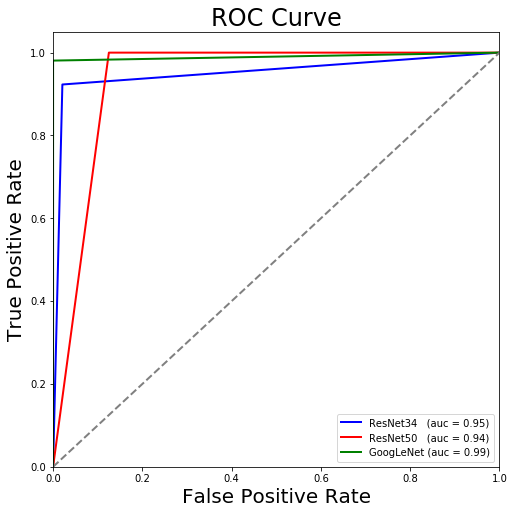

In [0]:
import numpy as np
from sklearn.metrics import roc_curve, auc
y = test_label

resnet_34_scores = resnet_34_predict
resnet_34_fpr, resnet_34_tpr, _ = roc_curve(y, resnet_34_scores)
resnet_34_roc_auc = auc(resnet_34_fpr, resnet_34_tpr)

resnet_50_scores = resnet_50_predict
resnet_50_fpr, resnet_50_tpr, _ = roc_curve(y, resnet_50_scores)
resnet_50_roc_auc = auc(resnet_50_fpr, resnet_50_tpr)

IV3_scores = IV3_predict
IV3_fpr, IV3_tpr, _ = roc_curve(y, IV3_scores)
IV3_roc_auc = auc(IV3_fpr, IV3_tpr)


import matplotlib as mpl
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
lw = 2
plt.plot(resnet_34_fpr, resnet_34_tpr, color='blue', lw=lw, label='ResNet34   (auc = %0.2f)' % resnet_34_roc_auc)
plt.plot(resnet_50_fpr, resnet_50_tpr, color='red', lw=lw, label='ResNet50   (auc = %0.2f)' % resnet_50_roc_auc)
plt.plot(IV3_fpr, IV3_tpr, color='green', lw=lw, label='GoogLeNet (auc = %0.2f)' % IV3_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.title('ROC Curve', fontsize=24)
plt.legend(loc="lower right")
fig.savefig('drive/My Drive/acer_intern/saved_model/roc.png')
plt.show()